In [7]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Sequence
import sklearn as sk

In [9]:
########### Auxullary functions ######################################
def line_data_generator(
        intercept   :   float,              # the
        slope       :   float,
        x_min       :   float   =   -5.0,
        x_max       :   float   =   5.0,
        num         :   float   =   100,
        noise       :   bool    =   True
):
    """
    author  :   Jwalit Panchal
    use     :   create noisy line data
    params  :   intercept   :   the intercept of the line y = mx + c
                slope       :   the slope of the line y = mx + c
                x_min       :   start of the domain of the line
                x_max       :   end of the domain of the line
                num         :   number of points in the data
    """
    x_list          =   np.linspace(x_min,x_max,num=num)
    y_list          =   np.zeros(num)
    if (noise==True):
        for index, x_pt in enumerate(x_list):
            y_list[index]   =   slope*x_pt + intercept + np.random.normal(loc=0,scale=1)
    else:
        for index, x_pt in enumerate(x_list):
            y_list[index]   =   slope*x_pt + intercept
    return  x_list, y_list

def r_gradient_descent_linear_r(
        x_data          :   Sequence[float],
        y_data          :   Sequence[float],
        learning_rate   :   float,
        epoch           :   int,
        tol             :   float,
        method          :   str     =   "matrix",
        plot            :   bool    =   False,
):
    """
    author  :   Jwalit Panchal
    use     :   does regular gradient descent for a line using mean square error for the loss function
    params  :   x_data- x_data
                y_data- noisy y data
                learning_rate-  the learning rate that will be used for updating the model fit parameters every iteration
                epoch-  number of iterations for model fitting (fn. will return which ever of the two, 
                        convergence or epoch, is first)
                tol-    tolerence for convergence
                method- the method that is used for calculating the gradient of loss function; by default it is
                        the matrix method; other allowed option is "direct"
                plot-   default False; if true, upon its call, the function will plot in a figure the noisy imput data
                        and the fitted line
    """
    # guessing the initial parameters m and c that will go into the model function y_hat=m*x_data + c
    beta        =   np.zeros(2)
    # initial guess of the parameters
    beta[0]     =   0.0
    beta[1]     =   0.0
    beta_new    =   beta
    loss_fn     =   []

    if (method == "matrix"):
        # construnct the X, and Y matrices and their transposes
        x_mat       =   np.zeros((len(x_data),2))
        x_mat[:,0]  =   1.0
        x_mat[:,1]  =   x_data[:]
        y_mat       =   np.zeros(len(y_data))
        y_mat[:]    =   y_data[:]
        # a 1d array for saving the predicted values using model

        for i in range(epoch):
            beta        =   beta_new
            xty         =   x_mat.T @ y_mat
            xtx         =   x_mat.T @ x_mat
            xtxb        =   xtx @ beta
            yty         =   y_data.T @ y_data
            gradient    =   2.0*(xtxb - xty)
            beta_new    =   beta - (learning_rate * gradient)
            y_predict   =   beta_new[0] + beta_new[1]*x_data
            loss        =   (beta.T @ (xtx @ beta) - 2.0 * (beta @ xty) + yty)/len(y_data)
            loss_fn.append(loss)
            if (np.sqrt(np.sum(np.square(beta-beta_new))) < tol):
                break
    elif (method=="direct"):
        gradient        =   np.zeros(2)
        for i in range(epoch):
            beta        =   beta_new
            # predicted value of function at x data points using the model line
            y_predict   =   beta[0] + beta[1]*x_data
            loss        =   np.sum(np.square(y_data - y_predict))/len(y_data)
            loss_fn.append(loss)
            # gradient of the loss function
            gradient[0] =   (-2.0/len(y_data)) * np.sum(y_data-y_predict)
            gradient[1] =   (-2.0/len(y_data)) * np.sum((x_data*y_data)-(x_data*y_predict))
            beta_new    =   beta - (learning_rate*gradient)
            if (np.sqrt(np.sum(np.square(beta_new-beta))) < tol):
                break
    else:
        raise ValueError("an invalide method is selected")
        
    
    if (plot == False):
        return  beta_new, loss_fn, y_predict
    elif (plot==True):
        predict_y   =   np.zeros(len(y_data))
        predict_y   =   beta[0] + beta[1] * x_data
        figsize =   (5,3)
        plt.figure(1, figsize=figsize)
        plt.scatter(x_data, y_data, s=2.5, color="green")
        plt.plot(x_data, predict_y, lw=2, label="fitted line")
        plt.legend(fontsize=15)
        plt.figure(2, figsize=figsize)
        plt.plot(np.linspace(0,i,num=i+1), loss_fn, lw=2, label="loss fn.")
        plt.legend(fontsize=15)
        plt.tight_layout()
        plt.show()
        return beta_new, loss_fn, y_predict
    
def stochastic_gd(
        x_data          :   Sequence[float],
        y_data          :   Sequence[float],
        learning_rate   :   float,
        epoch           :   int,
        tol             :   float,
        plot            :   bool    =   False,
):
    """
    author  :   Jwalit Panchal
    use     :   does regular gradient descent for a line using mean square error for the loss function
    params  :   x_data- x_data
                y_data- noisy y data
                learning_rate-  the learning rate that will be used for updating the model fit parameters every iteration
                epoch-  number of iterations for model fitting (fn. will return which ever of the two, 
                        convergence or epoch, is first)
                tol-    tolerence for convergence
                plot-   default False; if true, upon its call, the function will plot in a figure the noisy imput data
                        and the fitted line
    """
    # guessing the initial parameters m and c that will go into the model function y_hat=m*x_data + c
    beta        =   np.zeros(2)
    y_fit       =   np.zeros(len(y_data))
    # initial guess of the parameters
    beta[0]     =   0.0
    beta[1]     =   0.0
    beta_new    =   beta
    loss_fn     =   []
    gradient    =   np.zeros(2)
    for i in range(epoch):
            beta        =   beta_new
            # randomly shuffle the dataset
            rand_int    =   np.random.randint(0,len(y_data))
            # predicted value of function at x data points using the model line
            y_predict   =   beta[0] + beta[1]*x_data[rand_int]
            loss        =   abs(y_data[rand_int] - y_predict)
            loss_fn.append(loss)
            # gradient of the loss function
            gradient[0] =   -2.0 * (y_data[rand_int]-y_predict)
            gradient[1] =   -2.0 * (x_data[rand_int]*(y_data[rand_int]-y_predict))
            beta_new    =   beta - (learning_rate*gradient)
            if (np.sqrt(np.sum(np.square(beta_new-beta))) < tol):
                break
    y_fit   =   beta[0] + beta[1]*x_data

    if (plot==True):
        figsize =   (5,3)
        plt.figure(1, figsize=figsize)
        plt.scatter(x_data, y_data, s=2.5, color="green")
        plt.plot(x_data, y_fit, lw=2, label="fitted line")
        plt.legend(fontsize=15)
        plt.figure(2, figsize=figsize)
        plt.plot(np.linspace(0,i,num=i+1), loss_fn, lw=2, label="loss fn.")
        plt.legend(fontsize=15)
        plt.tight_layout()
        plt.show()
    return beta_new, loss_fn, y_fit

def r_square():
    return
########### Auxullary functions ######################################

in following cell, using random number generator funtion above, to get noisy x and y data

In [3]:
# generate random data
np.random.seed(40)
intercept           =       5.0
slope               =       2.5
x_data, y_data      =       line_data_generator(intercept=intercept, slope=slope)

# use the user defined fn. for doing gradient descent method
learning_rate       =       0.01
epoch               =       1000
tol                 =       1e-7

in the following cell, using the function regular gradient descent linear regression we will generate the predicted y values (y_cap), which will be used for plotting the data and also calclating the coefficient of determination (R-squared) (first independently and later using sklearn):

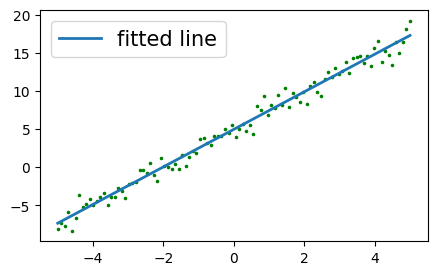

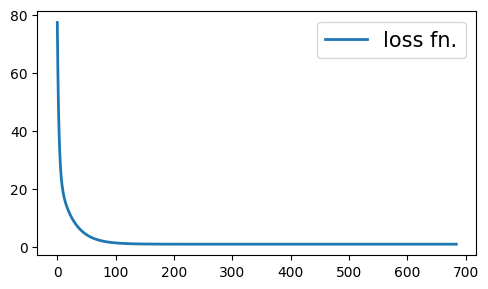

0.9822076643191107
0.9822076643191107


In [8]:
_, _, y_cap    =    r_gradient_descent_linear_r(x_data=x_data, y_data=y_data, learning_rate=learning_rate, epoch=epoch, tol=tol, method="direct",plot=True)

# calculating the R-squared value using i) rss and ii) tss:
# rss:
rss    =    np.sum(np.square(y_data - y_cap))
tss    =    np.sum(np.square(y_data - np.average(y_data)))
r_sq   =    1-(rss/tss)
print(r_sq)
r_sq_from_sklearn    =    sk.metrics.r2_score(y_true=y_data, y_pred=y_cap)
print(r_sq_from_sklearn)